# Checking out Slope Fitting - Different Methods

In [6]:
# This notebook uses py2.7 - because that's what FOOF is written in
from __future__ import print_function, division

In [7]:
# Bayes FOOF has a dependency of sklearn version >= 0.18.0. Check this.
import sklearn
assert sklearn.__version__[:4] == '0.18'

In [8]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import RANSACRegressor

In [9]:
# Import custom
from slf.plts.psd import *
from slf.core.utils import *

In [10]:
# Import FOOF - Set which version to import
#  NOTE: this is super messy / dangerous path usage - bad Tom. 
#    (Also, this only works on Tom's laptop atm.)
#    The mess is to compare FOOF versions. Soon move to new FOOF only.

# Set which version of foof to use
foof_ver = 'old'
import sys

if foof_ver == 'old':
    # Import FOOF (old version, in GitCode)
    sys.path.append('/Users/thomasdonoghue/Documents/GitCode')
    from foof.fit import FOOF
    
if foof_ver == 'bayes':
    # Import Bayes FOOF is currently on desktop to keep out of way of old FOOF
    sys.path.append('/Users/thomasdonoghue/Desktop/')
    from foof.fit import FOOF
    
# Either way import (same) syn functions
from foof import syn

In [11]:
# Load data from Jorge (Chicage group doing slope fitting)
dat = np.load('data/data-for-tom.npy').item()

In [12]:
# Get freqs & unembed from being an array of arrays
freqs = dat['f']
freqs = [f[0] for f in freqs]

slf/plts/psd.py:16: RuntimeWarning: divide by zero encountered in log10
  freqs = np.log10(freqs)


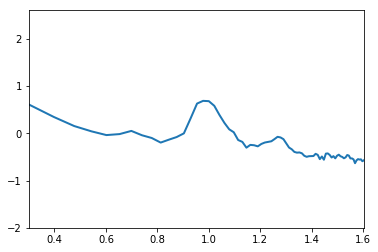

In [13]:
# Check plot - single PSD
plt_psd_1(freqs, dat[0][0]['eyesc'])

slf/plts/psd.py:35: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(True)
/Users/thomasdonoghue/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/thomasdonoghue/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")
slf/plts/psd.py:37: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(False)


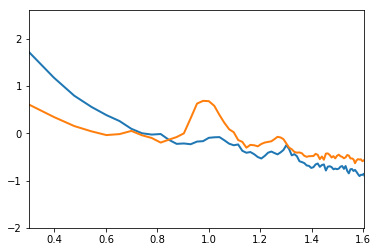

In [14]:
# Compare eyes open / eyes closed: single subject, single channel
plt_psd_2(freqs, dat[0][0]['eyeso'], freqs, dat[0][0]['eyesc'])

## FOOFing Data

In [15]:
# Set a PSD to run with FOOF
psd = dat[0][1]['eyesc']
psd_ext, freqs_ext = extract_psd(psd, freqs, 3, 40)

In [16]:
# Settings for FOOF
min_p = 0.2
freq_res = np.mean(np.diff(freqs))

In [17]:
# Initialize FOOF, fit PSD, and extract fit data
if foof_ver == 'old':
    foof = FOOF(min_p=min_p, res=freq_res, fmin=freqs_ext.min(), fmax=freqs_ext.max())
    foof.model(freqs_ext, psd_ext)
if foof_ver == 'bayes':
    foof = FOOF(freqs_ext, res=freq_res, min_p=min_p)
    foof.fit(psd_ext)

/Users/thomasdonoghue/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/thomasdonoghue/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/thomasdonoghue/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/thomasdonoghue/

In [18]:
# Extract foof fit data
foof_dat = (foof.chi_, foof.centers_, foof.powers_, foof.stdevs_)
sl_foof = -foof.chi_

In [19]:
# Check FOOF outputs
#  foof_dat is [slope_val, [center frequencies], [oscillation powers], [oscillation bandwidths]]
foof_dat

(0.73078125804331651,
 array([ 10.49034642,  18.18227714]),
 array([ 3.92095613,  0.88127655], dtype=float32),
 array([ 1.27399355,  1.27399355]))

## Checking FOOF PSD Fit

In [20]:
# Generate synthetic PSD from extracted FOOF parameters
fs, foof_model = syn.mfonef(
    mf=foof.centers_,
    mf_sig=foof.stdevs_,
    mk=foof.powers_,
    chi=foof.chi_,
    f0=freqs_ext.min(),
    fmax=freqs_ext.max(),
    res=freq_res,
    noi=0
)

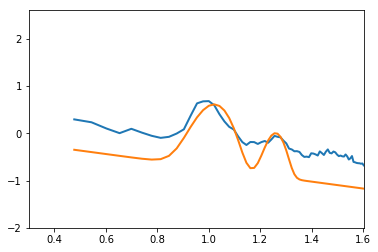

In [21]:
# Plot FOOF model of the PSD, with actual PSD
plt_psd_2(freqs_ext, psd_ext, fs, foof_model)
# Note: not sure why there is an offset, or whether that matters

# Robust Fitting PSDs

## Robust Slope Fitting with RLM

In [22]:
# Add constant for fitting with statsmodels
fx = sm.add_constant(np.log10(freqs_ext))

In [23]:
# Fit slope - robust linear fit to log-log PSD
fit_rlm = sm.RLM(np.log10(psd_ext), fx).fit()
sl_rlm = fit_rlm.params[1]

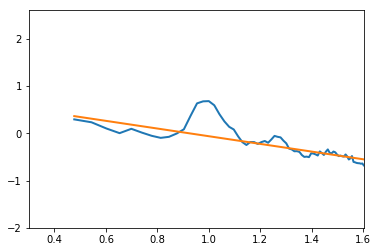

In [24]:
# Check the robust linear slope fit
plt_psd_2(freqs_ext, psd_ext, freqs_ext, np.power(10, fit_rlm.fittedvalues), log_f=True)

## Robust Fitting with RANSAC

In [25]:
# Reshape freqs for RANSAC fit
freqs_ext = freqs_ext.reshape([len(freqs_ext), 1])

In [26]:
# Initialize and fit with RANSAC
ransac_model = RANSACRegressor()
ransac_model.fit(np.log10(freqs_ext), np.log10(psd_ext))
sl_ran = ransac_model.estimator_.coef_[0][0]

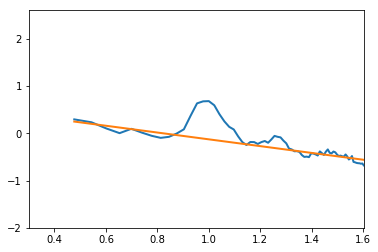

In [27]:
# Plot the slope fit, from RANSAC
plt_psd_2(freqs_ext, psd_ext, freqs_ext, np.power(10, ransac_model.predict(np.log10(freqs_ext))))

# Slope Fitting Excluding Alpha

In [28]:
# Exclude predefined alpha range
psd_alph, freqs_alph = exclude_psd(psd_ext, freqs_ext, [7, 14])

## RLM Slope Fitting Excluding Generic Alpha Band

In [29]:
# Robust fit slope without alpha range
fx = sm.add_constant(np.log10(freqs_alph))
fit_rlm_alph = sm.RLM(np.log10(psd_alph), fx).fit()
sl_rlm_alph = fit_rlm_alph.params[1]

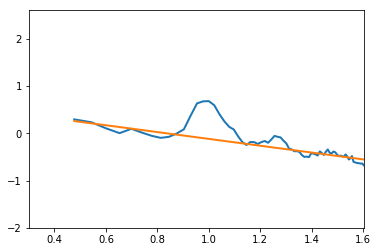

In [30]:
# Plot the slope fit, with alpha exclusion range (note plots original PSD with alpha included)
plt_psd_2(freqs_ext, psd_ext, freqs_alph, np.power(10, fit_rlm_alph.fittedvalues), log_f=True)

## RANSAC Slope Fitting Excluding Generic Alpha Band

In [31]:
# Fit alpha-exclusion with RANSAC
ransac_model_alph = RANSACRegressor()
ransac_model_alph.fit(np.log10(freqs_alph), np.log10(psd_alph))
sl_ran_alph = ransac_model_alph.estimator_.coef_[0][0]

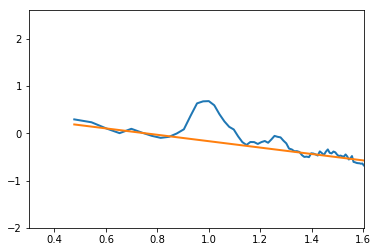

In [32]:
# Plot the slope fit, with osc excluded (note: plots original PSD with oscs included)
plt_psd_2(freqs_ext, psd_ext, freqs_alph, np.power(10, ransac_model_alph.predict(np.log10(freqs_alph))))

# Slope Fitting Excluding Oscillations

In [33]:
# Foof dat is [slope_val, [centers], [powers], [bandwidths]]
foof_dat

(0.73078125804331651,
 array([ 10.49034642,  18.18227714]),
 array([ 3.92095613,  0.88127655], dtype=float32),
 array([ 1.27399355,  1.27399355]))

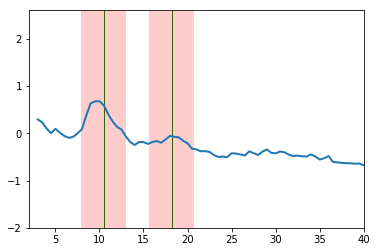

In [34]:
# Note:
#  Here 'm' is a parameter, the number of std-deviations, to exclude, for each oscillation
#    The current value of m was chosen arbitrarily

m = 2.0

plt_psd_1(freqs_ext, psd_ext, log_f=False)

# Add shading to see where oscillations are and what will be excluded
for cen, bw in zip(foof_dat[1], foof_dat[3]):
    plt.axvspan(cen, cen, color='g')
    plt.axvspan(cen-(m*bw), cen+(m*bw), color='r', alpha=0.2, lw=0)

In [35]:
# Exclude FOOF oscillation bands
psd_excl = psd_ext
freqs_excl = freqs_ext
for cen, bw in zip(foof_dat[1], foof_dat[3]):
    psd_excl, freqs_excl = exclude_psd(psd_excl, freqs_excl, [cen-m*bw, cen+m*bw])

## RLM Slope Fitting Excluding Oscillatory Bands

In [36]:
# Robust fit slope without FOOF oscillation bands
fx = sm.add_constant(np.log10(freqs_excl))
fit_rlm_excl = sm.RLM(np.log10(psd_excl), fx).fit()
sl_rlm_excl = fit_rlm_excl.params[1]

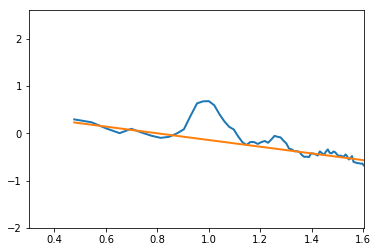

In [37]:
# Plot the slope fit, with osc excluded (note: plots original PSD with oscs included)
plt_psd_2(freqs_ext, psd_ext, freqs_excl, np.power(10, fit_rlm_excl.fittedvalues), log_f=True)

## RANSAC Slope Fitting Excluding Oscillatory Bands

In [38]:
# Fit alpha-exclusion with RANSAC
ransac_model_excl = RANSACRegressor()
ransac_model_excl.fit(np.log10(freqs_excl), np.log10(psd_excl))
sl_ran_excl = ransac_model_excl.estimator_.coef_[0][0]

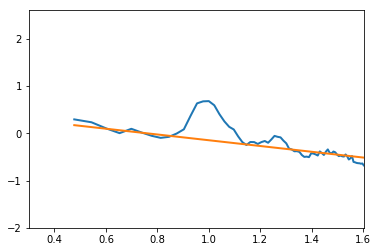

In [39]:
# Plot the slope fit, with osc excluded (note: plots original PSD with oscs included)
plt_psd_2(freqs_ext, psd_ext, freqs_excl, np.power(10, ransac_model_excl.predict(np.log10(freqs_excl))))

# Compare Slope Fits

Note: FOOF uses RANSAC, so any differences here are simply due to random initializations

In [40]:
print('FOOF: \t\t\t', sl_foof)
print('RLM: \t\t\t', sl_rlm)
print('RLM-Exclude Alpha:\t', sl_rlm_alph)
print('RLM-Exclude Oscs:\t', sl_rlm_excl)
print('RANSAC:\t\t\t', sl_ran)
print('RANSAC-Exclude Alpha:\t', sl_ran_alph)
print('RANSAC-Exclude Oscs:\t', sl_ran_excl)

FOOF: 			 -0.730781258043
RLM: 			 -0.813382243358
RLM-Exclude Alpha:	 -0.722897254535
RLM-Exclude Oscs:	 -0.709775018852
RANSAC:			 -0.719352173267
RANSAC-Exclude Alpha:	 -0.677773179217
RANSAC-Exclude Oscs:	 -0.610435094655


In [41]:
# Print out in order of slope fit magnitude
all_sl_fits = [(sl_rlm, 'RLM'), (sl_rlm_alph, 'RLM-EA'), (sl_rlm_excl, 'RLM-EO'),
               (sl_ran, 'RANSAC'), (sl_ran_alph, 'RAN-EA'), (sl_ran_excl, 'RAN-EO'),
               (sl_foof, 'FOOF')]
all_sl_fits.sort()
all_sl_fits.reverse()
all_sl_fits

[(-0.61043509465497148, 'RAN-EO'),
 (-0.6777731792167373, 'RAN-EA'),
 (-0.70977501885186589, 'RLM-EO'),
 (-0.71935217326679413, 'RANSAC'),
 (-0.72289725453462439, 'RLM-EA'),
 (-0.73078125804331651, 'FOOF'),
 (-0.81338224335826881, 'RLM')]